In [1]:
import sys
import re
import array
import os
import gzip, ubjson
import numpy as np
import pickle,itertools
from collections import Counter
from collections import defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy import special

# Tokenization 

In [2]:
def tokenize(text):
    STARTING_QUOTES = [
        (re.compile(r'^\"'), r'``'),
        (re.compile(r'(``)'), r' \1 '),
        (re.compile(r"([ \(\[{<])(\"|\'{2})"), r'\1 `` '),
    ]
    # punctuation
    PUNCTUATION = [
        (re.compile(r'([:,])([^\d])'), r' \1 \2'),
        (re.compile(r'([:,])$'), r' \1 '),
        (re.compile(r'\.\.\.'), r' ... '),
        (re.compile(r'[;@#$%&]'), r' \g<0> '),
        (re.compile(r'([^\.])(\.)([\]\)}>"\']*)\s*$'), r'\1 \2\3 '),  # Handles the final period.
        (re.compile(r'[?!]'), r' \g<0> '),

        (re.compile(r"([^'])' "), r"\1 ' "),
    ]
    # Pads parentheses
    PARENS_BRACKETS = (re.compile(r'[\]\[\(\)\{\}\<\>]'), r' \g<0> ')
    # Optionally: Convert parentheses, brackets and converts them to PTB symbols.
    CONVERT_PARENTHESES = [
        (re.compile(r'\('), '-LRB-'), (re.compile(r'\)'), '-RRB-'),
        (re.compile(r'\['), '-LSB-'), (re.compile(r'\]'), '-RSB-'),
        (re.compile(r'\{'), '-LCB-'), (re.compile(r'\}'), '-RCB-')
    ]
    DOUBLE_DASHES = (re.compile(r'--'), r' -- ')
    # ending quotes
    ENDING_QUOTES = [
        (re.compile(r'"'), " '' "),
        (re.compile(r'(\S)(\'\')'), r'\1 \2 '),
        (re.compile(r"([^' ])('[sS]|'[mM]|'[dD]|') "), r"\1 \2 "),
        (re.compile(r"([^' ])('ll|'LL|'re|'RE|'ve|'VE|n't|N'T) "), r"\1 \2 "),
    ]
    # List of contractions adapted from Robert MacIntyre's tokenizer.
    CONTRACTIONS2 = list(map(re.compile, [r"(?i)\b(can)(?#X)(not)\b",
                         r"(?i)\b(d)(?#X)('ye)\b",
                         r"(?i)\b(gim)(?#X)(me)\b",
                         r"(?i)\b(gon)(?#X)(na)\b",
                         r"(?i)\b(got)(?#X)(ta)\b",
                         r"(?i)\b(lem)(?#X)(me)\b",
                         r"(?i)\b(mor)(?#X)('n)\b",
                         r"(?i)\b(wan)(?#X)(na)\s"]))
    CONTRACTIONS3 = list(map(re.compile, [r"(?i) ('t)(?#X)(is)\b", r"(?i) ('t)(?#X)(was)\b"]))
    for regexp, substitution in STARTING_QUOTES:
        text = regexp.sub(substitution, text)
    for regexp, substitution in PUNCTUATION:
        text = regexp.sub(substitution, text)
    # Handles parentheses.
    regexp, substitution = PARENS_BRACKETS
    text = regexp.sub(substitution, text)
    # Optionally convert parentheses
    for regexp, substitution in CONVERT_PARENTHESES:
        text = regexp.sub(substitution, text)
    # Handles double dash.
    regexp, substitution = DOUBLE_DASHES
    text = regexp.sub(substitution, text)
    # add extra space to make things easier
    text = " " + text + " "
    for regexp, substitution in ENDING_QUOTES:
        text = regexp.sub(substitution, text)
    for regexp in CONTRACTIONS2:
        text = regexp.sub(r' \1 \2 ', text)
    for regexp in CONTRACTIONS3:
        text = regexp.sub(r' \1 \2 ', text)
    tokens=text.split()
    return tokens


def find_sentences(text_file):
    output_file="segmented_sents.txt"
    cmd = "segmenter "+text_file+" > "+output_file
    os.system(cmd)
    sentences=[]
    with open(output_file,"r") as fl:
        for line in fl:
            if len(line.strip())>0:
                sentences.append(line.strip())
    fl.close()
    return sentences

# UTILITIES 

In [3]:
def rename_files(data_path):
    i=1
    for file in os.listdir(data_path):
        os.rename(os.path.join(data_path, file), os.path.join(data_path, str(i)+'.txt'))
        i+=1
    
def extract_data(data_path):
    data=data_path
    corpus=[]
    cnt=2
    for file in os.listdir(data):
        for sent in find_sentences(data+file):
            #print(sent)
            corpus.append(tokenize(sent))
        #cnt+=-1
        #if cnt==0:
            #break        
    return corpus 

def load(filename):
    with gzip.open(filename, 'rb') as f:
        return ubjson.load(f)
    
def save(filename,obj):
    with gzip.open(filename, 'wb') as f:
        ubjson.dump(obj, f) 

def calc_ngrams(sent_tags, n):
    ngrams = list(zip(*[sent_tags[i:] for i in range(n)]))
    return ngrams


In [4]:
script_path=os.path.dirname(os.path.abspath('__file__'))
data=script_path+"/Gutenberg/txt/"
#rename_files(data)
#corpus = extract_data(data)
#save("corpus.txt",corpus)

## LOAD CORPUS

In [5]:
corpus = load("corpus.txt")
unique_tokens = set(x for l in corpus for x in l)

## STATISTICS OF DATA

In [6]:
print("Total sentences: ",len(corpus))
print("Total unigrams/words: ",sum([len(sent) for sent in corpus]))
print("Total bigrams: ",sum([len(ngrams) for sent in corpus for ngrams in calc_ngrams(sent,2)]))
print("Total trigrams: ",sum([len(ngrams) for sent in corpus for ngrams in calc_ngrams(sent,3)]))
print("Unique tokens: ",len(unique_tokens))

Total sentences:  12760181
Total unigrams/words:  124163963
Total bigrams:  222807564
Total trigrams:  296685381
Unique tokens:  654194


## Calculate zipf and plot the data

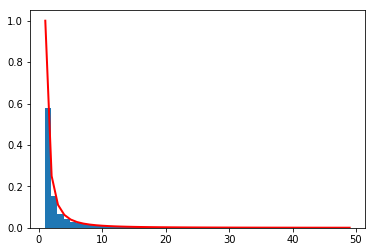

In [8]:
frequency = Counter(itertools.chain(*corpus))
s = frequency.values()
s = np.array(list(s))
a = 2. #  distribution parameter
count, bins, ignored = plt.hist(s[s<50], 50, density=True)
x = np.arange(1., 50.)
y = x**(-a) / special.zetac(a)
plt.plot(x, y/max(y), linewidth=2, color='r')
plt.show()

# MLE N-gram counts and probabilities 

In [9]:

def calc_MLE_counts(corpus,lvl="word"):
    unigram_c = defaultdict(int)
    bigram_c = defaultdict(int)
    trigram_c = defaultdict(int)
    if lvl!="word":
        for sent in corpus:
            for word in sent:
                
                unigrams=calc_ngrams(list(word),1)
                bigrams=calc_ngrams(list(word),2)
                trigrams=calc_ngrams(list(word),3)
                
                for unigram in unigrams:
                    unigram_c[unigram] += 1

                for bigram in bigrams:
                    bigram_c[bigram] += 1

                for trigram in trigrams:
                    trigram_c[trigram] += 1

    else:    
        for sent in corpus:
            unigrams = calc_ngrams(sent, 1)
            bigrams = calc_ngrams(sent, 2)
            trigrams = calc_ngrams(sent, 3)

            for unigram in unigrams:
                unigram_c[unigram] += 1

            for bigram in bigrams:
                bigram_c[bigram] += 1

            for trigram in trigrams:
                trigram_c[trigram] += 1

    return unigram_c, bigram_c, trigram_c

def ml_prob(ngram,counts): ## ngram :- [w1,w2,w3]
    ngram=tuple(ngram)
    if len(ngram)==1:
        unigrams=counts[0]
        if ngram in unigrams:
            prob=unigrams[ngram]/float(sum(unigrams.values()))
        else:
            prob=0
    elif len(ngram)==2:
        unigrams=counts[0]
        bigrams=counts[1]
        w1=ngram[0]
        w2=ngram[1]
        if ngram in bigrams:
            prob = bigrams[ngram]/float(unigrams[ngram[0:1]])
        else:
            prob=0
    else:
        bigrams=counts[1]
        trigrams=counts[2]
        if ngram in trigrams:
            prob=trigrams[ngram]/float(bigrams[ngram[0:2]])
        else:
            prob=0
    return prob


In [16]:
#word_uni,word_bi,word_tri = calc_MLE_counts(corpus)
#ch_uni,ch_bi,ch_tri = calc_MLE_counts(corpus,"char")

## Saving word and character MLE counts

In [17]:
'''file = open("word_uni.pickle","wb")
pickle.dump(word_uni,file)
file.close()

file = open("word_bi.pickle","wb")
pickle.dump(word_bi,file)
file.close()

file = open("word_tri.pickle","wb")
pickle.dump(word_tri,file)
file.close()

file = open("ch_uni.pickle","wb")
pickle.dump(ch_uni,file)
file.close()

file = open("ch_bi.pickle","wb")
pickle.dump(ch_bi,file)
file.close()

file = open("ch_tri.pickle","wb")
pickle.dump(ch_tri,file)
file.close()'''

## Loading word and character MLE counts

In [18]:
file = open("word_uni.pickle","rb")
word_uni = pickle.load(file)
file.close()

file = open("word_bi.pickle","rb")
word_bi = pickle.load(file)
file.close()

file = open("word_tri.pickle","rb")
word_tri = pickle.load(file)
file.close()

file = open("ch_uni.pickle","rb")
ch_uni = pickle.load(file)
file.close()

file = open("ch_bi.pickle","rb")
ch_bi = pickle.load(file)
file.close()

file = open("ch_tri.pickle","rb")
ch_tri = pickle.load(file)
file.close()

# Smoothing methods

In [19]:
def laplace_smoothing(ngram,counts):
    ngram=tuple(ngram)
    if len(ngram)==1:
        unigrams=counts[0]
        N=sum(unigrams.values())
        V=len(unigrams)
        if ngram in unigrams:
            prob = (unigrams[ngram]+1)/float(N+V)
        else:
            prob = 1/float(N+V)

    elif len(ngram)==2:
        unigrams=counts[0]
        bigrams=counts[1]
        V=len(unigrams)
        if ngram in bigrams:
            prob = (bigrams[ngram]+1)/float(unigrams[ngram[0:1]]+V)
        else:
            if ngram[0:1] in unigrams:
                prob = 1/float(unigrams[ngram[0:1]]+V)
            else:
                prob = 1/float(V)
    else:
        unigrams=counts[0]
        bigrams=counts[1]
        trigrams=counts[2]
        V=len(unigrams)
        if ngram in trigrams:
            prob = (trigrams[ngram]+1)/float(bigrams[ngram[0:2]]+V)
        else:
            if ngram[0:2] in bigrams:
                prob = 1/float(bigrams[ngram[0:2]]+V)
            else:
                prob = 1/float(V)
    return prob

def good_turing(ngram,counts):
    V=sum(counts[0].values())
    ngram=tuple(ngram)
    l=len(ngram)
    ngrams=counts[l-1]
    N=sum(ngrams.values())
    nrs={}
    for k,v in ngrams.items():
        if v not in nrs:
            nrs[v].append(k) ## dictionary of (key=freq of ngram) and (value = list of all ngram tuple whose freq. is key)
    nr_counts={k:len(v) for k,v in nrs.items()}
    if 0 not in nr_counts:
        nr_counts[0]=V**l - N
    else:
        nr_counts[0]+=V**l - N
    MAX=sorted(nr_counts.items())[0][1] ##max freq of ngram in corpus
    new_nrs={}
    for r, nr in nr_counts.items():
        if (r+1) in nr_counts:
            new_nr=(r+1)*nr_counts[r+1]/float(N)
        else:
            new_nr=MAX*r**-2/float(N)
        new_nrs[r]=new_nr

    if ngrams[ngram]>5:
        prob=ml_prob(ngram,counts)
    else:
        denominator=(1 - 6*new_nrs[6]/float(new_nrs[1]))/float(N)
        if ngram in ngrams:
            numerator=(ngrams[ngram]+1)*new_nrs[ngrams[ngram]+1]/float(new_nrs[ngrams[ngram]])
            mod_num=num - ngrams[ngram]*6*new_nrs[6]/float(new_nrs[1])
            prob = mod_num/float(denominator)
        else:
            prob = new_nrs[1]/(new_nrs[0]*float(denominator)) ##not considering singleton ngrams as unseen
    return prob

def witten_bell(ngram,counts):
    ngram=tuple(ngram)
    if len(ngram)==2:
        unigrams=counts[0]
        bigrams=counts[1]
        ngram_count=bigrams[ngram]
        prior_count=unigrams[ngram[0:1]]
        type_count=0
        s=0
        for bigram in bigrams:
            if bigram[0]==ngram[0:1]:
                type_count+=1
                s+=bigrams[bigram]
        vocab_size=len(bigrams)
        z = vocab_size - type_count
        if ngram_count==0:
            prob = type_count/float(z*(prior_count+type_count))
        else:
            prob = ngram_count/float(prior_count + type_count)
        wb_lambda=1-bigrams[bigram]/float(bigrams[bigram]+s)
        prob=(wb_lambda)*prob+(1-wb_lambda)*unigrams[ngram[1:2]]/float(sum(unigrams.values()))
    else:
        unigrams=counts[0]
        bigrams=counts[1]
        trigrams=counts[2]
        ngram_count = trigrams[ngram]
        prior_count = bigrams[ngram[0:2]]
        type_count=0
        s=0
        for trigram in trigrams:
            if ngram[0:1]==trigram[0] and ngram[1:2]==trigram[1]:
                type_count+=1
                s+=trigrams[trigram]
        vocab_size = len(trigrams)
        z = vocab_size - type_count
        if ngram_count == 0:
            prob = type_count/float(z*(prior_count + type_count))
        else:
            prob = ngram_count/float(prior_count + type_count)
        wb_lambda=1-trigrams[trigram]/float(trigrams[trigram]+s)
        prob=(wb_lambda)*prob+(1-wb_lambda)*bigrams[ngram[1:3]]/float(unigrams[ngram[1:2]])
    return prob

def stupid_backoff(ngram,counts):
    ngram=tuple(ngram)
    ans=0
    if len(ngram)==2:
        unigrams=counts[0]
        bigrams=counts[1]
        if ngram in bigrams:
            denominator=0
            for bigram in bigrams:
                if ngram[0:1]==bigram[0]:
                    denominator+=bigrams[bigram]
            ans=bigram[ngram]/float(denominator)
        if ans==0:
            if ngram[1:2] in unigrams:
                ans = 0.4 * unigrams[ngram[1:2]]/float(sum(unigrams.values()))
    else:
        unigrams=counts[0]
        bigrams=counts[1]
        trigrams=counts[2]
        if ngram in trigrams:
            denominator=0
            for trigram in trigrams:
                if ngram[0:1]==trigram[0] and ngram[1:2]==trigram[1]:
                    denominator+=trigrams[trigram]
            ans=trigrams[ngram]/float(denominator)
        if ans==0:
            if ngram[1:3] in bigrams:
                denominator=0
                for bigram in bigrams:
                    if ngram[1:2]==bigram[0]:
                        denominator+=bigrams[bigram]
                ans=0.4*bigrams[ngram[1:3]]/float(denominator)
        if ans==0:
            if ngram[2:3] in unigrams:
                ans = 0.16*unigrams[ngram[2:3]]/float(sum(unigrams.values()))
    return ans

def katz_backoff(ngram,counts):
    ngram=tuple(ngram)
    if len(ngram)==2:
        unigrams=counts[0]
        bigrams=counts[1]
        r = bigrams[ngram]
        k=5
        ngrams=bigrams
        N=sum(ngrams.values())
        nrs={}
        for k,v in ngrams.items():
            if v not in nrs:
                nrs[v].append(k) ## dictionary of key as freq of ngram and value as list of all ngram tuple
        nr_counts={k:len(v) for k,v in nrs.items()}
        MAX=sorted(nr_counts.items())[0][1] ##max freq of ngram in corpus
        new_nrs={}
        for r, nr in nr_counts.items():
            if (r+1) in nr_counts:
                new_nr=(r+1)*nr_counts[r+1]/float(N)
            else:
                new_nr=MAX*r**-2/float(N)
            new_nrs[r]=new_nr
        num1 = (r+1)*new_nrs[r+1]/float(r*new_nrs[r])
        num2 = (k+1)*new_nrs[k+1]/float(new_nrs[1])
        deno =  1 - (k+1)*new_nrs[k+1]/float(new_nrs[1])
        dr = (num1 - num2)/float(deno)
        s=0
        for bigram in bigrams:
            if bigram[0]==ngram[0:1]:
                s+=good_turing([bigram[0],bigram[1]],counts)
        numerator=1-s
        s=0
        for unigram in unigrams:
            s+=good_turing([unigram[0]],counts)
        denominator=1-s
        alpha = numerator/float(denominator)
        if r>k:
            prob = good_turing([ngram[0:1][0],ngram[1:2][0]],counts)
        elif r>0 and r<=k:
            prob = dr*good_turing([ngram[0:1][0],ngram[1:2][0]],counts)
        else:
            prob = alpha*good_turing([ngram[1:2][0]],counts)
    else:
        unigrams=counts[0]
        bigrams=counts[1]
        trigrams=counts[2]
        r1 = trigrams[ngram]
        r2= bigrams[ngram[1:3]]
        s1=0
        for trigram in trigrams:
            if trigram[0]==ngram[0:1] and trigram[1]==ngram[1:2]:
                s1+=good_turing([trigram[0],trigram[1],trigram[2]],counts)
        num=1-s1
        s1=0
        for bigram in bigrams:
            if bigram[0]==ngram[1:2]:
                s1+=good_turing([bigram[0],bigram[1]],counts)
        deno=1-s1
        alpha1=num/float(deno)
        s2=0
        for bigram in bigrams:
            if bigram[0]==ngram[1:2]:
                s+=good_turing([bigram[0],bigram[1]],counts)
        numerator=1-s
        s2=0
        for unigram in unigrams:
            s2+=good_turing([unigram[0]],counts)
        denominator=1-s
        alpha2 = numerator/float(denominator)
        if r1>0:
            prob=good_turing([ngram[0:1][0],ngram[1:2][0],ngram[2:3][0]],counts)
        elif r1==0 and r2>0:
            prob=alpha1*good_turing([ngram[1:2][0],ngram[2:3][0]],counts)
        else:
            prob=alpha2*good_turing([ngram[2:3][0]],counts)
    return prob

# Language Model with smoothing

In [20]:
def language_model(model_name,counts,n):
    ##model_name :- "lap","gt","wb", "sbo", "kbo" [laplace/add-1,good-turing,witten_bell,stupid_backoff,katz-backoff]
    unigrams=counts[0]
    bigrams=counts[1]
    trigrams=counts[2]
    unigram_prob=defaultdict(float)
    bigram_prob=defaultdict(float)
    trigram_prob=defaultdict(float)
    if n==1:
        for unigram in unigrams:
            if model_name=="lap":
                unigram_prob[unigram]=laplace_smoothing([unigram[0]],counts)
            elif model_name=="gt":
                unigram_prob[unigram]=good_turing([unigram[0]],counts)
        return unigram_prob

    elif n==2:
        for bigram in bigrams:
            if model_name=="lap":
                bigram_prob[bigram]=laplace_smoothing([bigram[0],bigram[1]],counts)
            elif model_name=="gt":
                bigram_prob[bigram]=good_turing([bigram[0],bigram[1]],counts)
            elif model_name=="wb":
                bigram_prob[bigram]=witten_bell([bigram[0],bigram[1]],counts)
            elif model_name=="sbo":
                bigram_prob[bigram]=stupid_backoff([bigram[0],bigram[1]],counts)
            else:
                bigram_prob[bigram]=katz_backoff([bigram[0],bigram[1]],counts)
        return bigram_prob

    else:
        for trigram in trigrams:
            if model_name=="lap":
                trigram_prob[trigram]=laplace_smoothing([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="gt":
                trigram_prob[trigram]=good_turing([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="wb":
                trigram_prob[trigram]=witten_bell([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="sbo":
                trigram_prob[trigram]=stupid_backoff([trigram[0],trigram[1],trigram[2]],counts)
            else:
                trigram_prob[trigram]=katz_backoff([trigram[0],trigram[1],trigram[2]],counts)
        return trigram_prob



In [21]:
word_uni_lap = language_model("lap",[word_uni,word_bi,word_tri],1)
word_uni_gt = language_model("gt",[word_uni,word_bi,word_tri],1)

word_bi_lap = language_model("lap",[word_uni,word_bi,word_tri],2)
word_bi_gt = language_model("gt",[word_uni,word_bi,word_tri],2)
word_bi_wb = language_model("wb",[word_uni,word_bi,word_tri],2)
word_bi_sbo = language_model("sbo",[word_uni,word_bi,word_tri],2)
word_bi_kbo = language_model("kbo",[word_uni,word_bi,word_tri],2)

word_tri_lap = language_model("lap",[word_uni,word_bi,word_tri],3)
word_tri_gt = language_model("gt",[word_uni,word_bi,word_tri],3)
word_tri_wb = language_model("wb",[word_uni,word_bi,word_tri],3)
word_tri_sbo = language_model("sbo",[word_uni,word_bi,word_tri],3)
word_tri_kbo = language_model("kbo",[word_uni,word_bi,word_tri],3)

KeyError: 2

## Saving LMs

In [ ]:
file = open("word_uni_lap.pickle","wb")
pickle.dump(word_uni_lap,file)
file.close()
file = open("word_uni_gt.pickle","wb")
pickle.dump(word_uni_gt,file)
file.close()

file = open("word_bi_lap.pickle","wb")
pickle.dump(word_bi_lap,file)
file.close()
file = open("word_bi_gt.pickle","wb")
pickle.dump(word_bi_gt,file)
file.close()
file = open("word_bi_wb.pickle","wb")
pickle.dump(word_bi_wb,file)
file.close()
file = open("word_bi_sbo.pickle","wb")
pickle.dump(word_bi_sbo,file)
file.close()
file = open("word_bi_kbo.pickle","wb")
pickle.dump(word_bi_kbo,file)
file.close()

file = open("word_tri_lap.pickle","wb")
pickle.dump(word_tri_lap,file)
file.close()
file = open("word_tri_gt.pickle","wb")
pickle.dump(word_tri_gt,file)
file.close()
file = open("word_tri_wb.pickle","wb")
pickle.dump(word_tri_wb,file)
file.close()
file = open("word_tri_sbo.pickle","wb")
pickle.dump(word_tri_sbo,file)
file.close()
file = open("word_tri_kbo.pickle","wb")
pickle.dump(word_tri_kbo,file)
file.close()

## Loading LMs

In [ ]:
file = open("word_uni_lap.pickle","rb")
word_uni_lap = pickle.load(file)
file.close()
file = open("word_uni_gt.pickle","rb")
word_uni_gt = pickle.load(file)
file.close()

file = open("word_bi_lap.pickle","rb")
word_bi_lap = pickle.load(file)
file.close()
file = open("word_bi_gt.pickle","rb")
word_bi_gt = pickle.load(file)
file.close()
file = open("word_bi_wb.pickle","rb")
word_bi_wb = pickle.load(file)
file.close()
file = open("word_bi_sbo.pickle","rb")
word_bi_sbo = pickle.load(file)
file.close()
file = open("word_bi_kbo.pickle","rb")
word_bi_kbo = pickle.load(file)
file.close()

file = open("word_tri_lap.pickle","rb")
word_tri_lap = pickle.load(file)
file.close()
file = open("word_tri_gt.pickle","rb")
word_tri_gt = pickle.load(file)
file.close()
file = open("word_tri_wb.pickle","rb")
word_tri_wb = pickle.load(file)
file.close()
file = open("word_tri_sbo.pickle","rb")
word_tri_sbo = pickle.load(file)
file.close()
file = open("word_tri_kbo.pickle","rb")
word_tri_kbo = pickle.load(file)
file.close()

# Find next word after given N-1 grams 

In [ ]:
def complete_ngram(ngram,counts,smoothing_method): ##ngram = [w1,w2] or [w1]
# Given (N-1) gram, and the value 'N', print the possibilities that complete the n-gram
# and plot them in decresing order of frequency
    next_gram=[]
    unigrams=counts[0]
    for word in unigrams:
        if len(ngram)==2:
            tokens=[ngram[0],ngram[1],word[0]]
        else:
            tokens=[ngram[0],word[0]]
        if smoothing_method=="lap":
            prob = laplace_smoothing(tokens,counts)
        elif smoothing_method=="gt":
            prob = good_turing(tokens,counts)
        elif smoothing_method=="wb":
            prob = witten_bell(tokens,counts)
        elif smoothing_method=="sbo":
            prob=stupid_backoff(tokens,counts)
        else:
            prob=katz_backoff(token,counts)
        next_gram.append((prob,word[0]))
    next_gram.sort(key=lambda tup: tup[0], reverse = True)
    return next_gram[0][1]


In [ ]:
inp="The man"
ngram=inp.split()
counts=[word_uni,word_bi,word_tri]
smoothing_method=["lap","gt","wb","sbo","kbo"]
for smoothing in smoothing_method:
    print("Smoothing: ",smoothing)
    print(complete_ngram(ngram,counts,smoothing))

# Edit Distance and candidates words

In [ ]:
def edit_distance(word,letters):
    #letters    = 'abcdefghijklmnopqrstuvwxyz' ##add additional characters
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def find_candidates(word,unique_tokens):
    ##Fusion words can also be computed in order to enhance the list
    letters=[]
    for token in unique_tokens:
        for ch in list(token):
            if ch not in letters:
                letters.append(ch)
    letters="".join(str(ch) for ch in letters)
    c4=set(word)
    if word in unique_tokens:
        c1=set(word)
    edit1=edit_distance(word,letters)
    tmp1=[]
    tmp2=[]
    for w1 in edit1:
        for w2 in edit_distance(w1,letters):
            if w2 in unique_tokens:
                tmp2.append(w2)
        if w1 in unique_tokens:
            tmp1.append(w1)
    c2=set(tmp1)
    c3=set(temp2)
    return list(c1|c2|c3|c4)


# Spell Checker

In [ ]:

def spell_checker(word,n,model_name,counts,unique_tokens):
# Given a word check if the spelling is correct using your Language model
# Feel free to add more helper functions for this task
# Giving candidate word with maximum probability using character L.M
# word level L.M is not computed and comapred against character level which is left for future task
    candidates=find_candidates(word,unique_tokens)
    cand_probs=[]
    for cand in candidates:
        cand_ch_grams=[cand[i:i+n] for i in range(len(cand)-n+1)]
        if n==1:
            prod=1
            for unigram in cand_ch_grams:
                if model_name=="lap":
                    prod*=laplace_smoothing([unigram],counts)
                elif model_name=="gt":
                    prod*=good_turing([unigram],counts)
        elif n==2:
            prod=1
            first_ch = list(cand_ch_grams[0])[0]
            prod*=good_turing([first_ch],counts)
            for bigram in cand_ch_grams:
                if model_name=="lap":
                    prod*=laplace_smoothing([list(bigram)[0],list(bigram)[1]],counts)
                elif model_name=="gt":
                    prod*=good_turing([list(bigram)[0],list(bigram)[1]],counts)
                elif model_name=="wb":
                    prod*=witten_bell([list(bigram)[0],list(bigram)[1]],counts)
                elif model_name=="sbo":
                    prod*=stupid_backoff([list(bigram)[0],list(bigram)[1]],counts)
                else:
                    prod*=katz_backoff([list(bigram)[0],list(bigram)[1]],counts)

        else:
            prod=1
            first_ch=list(cand_ch_grams[0])[0]
            second_ch=list(cand_ch_grams[0])[1]
            prod*=good_turing([first_ch],counts)
            prod*=good_turing([first_ch,second_ch],counts)
            for trigram in cand_ch_grams:
                if model_name=="lap":
                    prod*=laplace_smoothing([list(trigram)[0],list(trigram)[1],list(trigram)[2]],counts)
                elif model_name=="gt":
                    prod*=good_turing([list(trigram)[0],list(trigram)[1],list(trigram)[2]],counts)
                elif model_name=="wb":
                    prod*=witten_bell([list(trigram)[0],list(trigram)[1],list(trigram)[2]],counts)
                elif model_name=="sbo":
                    prod*=stupid_backoff([list(trigram)[0],list(trigram)[1],list(trigram)[2]],counts)
                else:
                    prod*=katz_backoff([list(trigram)[0],list(trigram)[1],list(trigram)[2]],counts)

        cand_probs.append((prob,cand))
    cand_probs.sort(key=lambda tup: tup[0], reverse = True)
    return cand_probs[0][1]



In [ ]:
input_word="catsq"
model_comb=[("lap","gt"),("lap","gt","wb","sbo","kbo")]
ns=[1,2,3]
counts=[ch_uni,ch_bi,ch_tri]
for n in ns:
    print("N: \n",n)
    if n==1:
        model_names = model_comb[0]
    else:
        model_names = model_comb[1]
    for model in model_names:
        print("Smoothing: ",model)
        print(spell_checker(input_word,n,model,counts))

# Grammaticality of sentence

In [ ]:
def score_grammaticality(sentence,n,model_name,counts):
  # Given a sentence, Build a model from the data which can give a score of grammaticality.
  # More grammatical the sentence, better the score
  # Feel free to add helper functions
    n_grams = list(zip(*[sentence.split()[i:] for i in range(n)]))
    if n==1:
        prod=1
        for unigram in n_grams:
            if model_name=="lap":
                prod*=laplace_smoothing([unigram[0]],counts)
            elif model_name=="gt":
                prod*=good_turing([unigram[0]],counts)
    elif n==2:
        prod=1
        first_word = n_grams[0][0]
        prod*=good_turing([first_word],counts)
        for bigram in n_grams:
            if model_name=="lap":
                prod*=laplace_smoothing([bigram[0],bigram[1]],counts)
            elif model_name=="gt":
                prod*=good_turing([bigram[0],bigram[1]],counts)
            elif model_name=="wb":
                prod*=witten_bell([bigram[0],bigram[1]],counts)
            elif model_name=="sbo":
                prod*=stupid_backoff([bigram[0],bigram[1]],counts)
            else:
                prod*=katz_backoff([bigram[0],bigram[1]],counts)

    else:
        prod=1
        first_word= n_grams[0][0]
        second_word=ngrams[0][1]
        prod*=good_turing([first_word],counts)
        prod*=good_turing([first_word,second_word],counts)
        for trigram in n_grams:
            if model_name=="lap":
                prod*=laplace_smoothing([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="gt":
                prod*=good_turing([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="wb":
                prod*=witten_bell([trigram[0],trigram[1],trigram[2]],counts)
            elif model_name=="sbo":
                prod*=stupid_backoff([trigram[0],trigram[1],trigram[2]],counts)
            else:
                prod*=katz_backoff([trigram[0],trigram[1],trigram[2]],counts)

    return prod

In [ ]:
sentence1='I have a red apple'
sentence2='apple a have I red'
print("Sentence1 :",sentence1)
print("Sentence2 :",sentence2)

model_comb=[("lap","gt"),("lap","gt","wb","sbo","kbo")]
ns=[1,2,3]
counts=[word_uni,word_bi,word_tri]
for n in ns:
    print("N: \n",n)
    if n==1:
        model_names = model_comb[0]
    else:
        model_names = model_comb[1]
    for model in model_names:
        print("Smoothing: ",model)
        print("Sentence1 Score: ",score_grammaticality(sentence1,n,model,counts))
        print("Sentence2 Score: ",score_grammaticality(sentence2,n,model,counts))